# ViraTrace model evaluation - Ferretti data

Evaluation of the ViraTrace model on the dataset provided by Luca Ferretti.


### Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import matplotlib.style as style
style.use('seaborn')

from sim_model import SimModel
from multisim_model import MultisimModel
from netgens import *
import networkx as nx

# must come after other imports to override standard tqdm
from tqdm.notebook import tqdm

### Ground truth simulation
Following section runs 100 simulations, first of which is used later as the ground truth.

In [2]:
INFECTED_P = 10/10_000
INFECTION_P = 0.02
RECOVERY_T = 15
RECOVERY_W = 5

N_DAYS = 50
N_SIMS = 100
SHARE_INIT = True

ANALYSIS_DAY = 10

N = 10000
edge_gen = edge_gen_ferretti()

INIT_INFECTED = np.full(N, False)
INIT_INFECTED[[7, 332, 445, 2364, 2656, 4168, 4453, 6097, 7752, 9505]] = True

model = MultisimModel(N, edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, initial_infected=INIT_INFECTED,
                      analysis_day=ANALYSIS_DAY, generate_daily_I=True,
                      tqdm=tqdm)
model.run_sim()

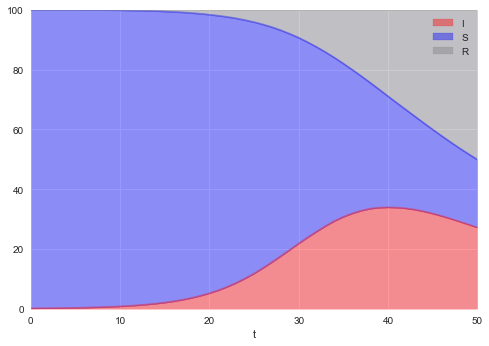

In [4]:
model.plot_stats()

### Model evaluation

In [12]:
# Generate daily infected data from the ground truth
# Ground truth is contained in model.daily_I

def generate_daily_data(daily_I, n_days, delay=7):
    new_daily_I = daily_I[:n_days-delay] + [None] * delay
    final_true_I = daily_I[n_days]
    return new_daily_I, final_true_I

In [15]:
# test for these N days
N_DAYS_LIST = [20,30]
# test for these daily test counts: 50% of tests are directly positive, and 50% are random
N_DAILY_TESTS_LIST = [8,16,32]

# node count
N = 10_000


# Same parameters as above
# To test the performance of "wrong" parameters, change them here
INFECTION_P = 0.02
RECOVERY_T = 15
RECOVERY_W = 5

# Delay between infection and test
TEST_DELAY = 7

# Max number of tests to try on the final day
N_TESTS = 400

# Total number of simulations (e.g. size of infection vectors) used in the model
N_SIMS = 500

result_df = pd.DataFrame({'n_tests': range(N_TESTS)})

for n_days in N_DAYS_LIST:
    for n_daily_tests in N_DAILY_TESTS_LIST:
        run_name = f'd_{n_days}_t_{n_daily_tests}'
        print(run_name)
        
        # positive tests
        daily_tests_p = int(n_daily_tests/2)
        # random tests
        daily_tests_r = int(n_daily_tests/2)
        # edge generator from ferretti data
        edge_gen = edge_gen_ferretti()
        
        # generate ground truth infections which are later sampled
        daily_I, final_true_I = generate_daily_data(model.daily_I, n_days, TEST_DELAY)
        
        # create model
        model_test = ContinuousMultisimModel(N, edge_gen, daily_I,
                                             INFECTION_P, RECOVERY_T, RECOVERY_W, n_days, N_SIMS,
                                             daily_tests_p, daily_tests_r, final_true_I, strong_negative=True,
                                             tqdm=tqdm)
        # run the model
        model_test.run_sim()
        
        # add risk scores to the result DF
        risks_df = pd.DataFrame({'node': range(N), 'risk': model_test.I.sum(axis=1), 
                         'positive': final_true_I, 'tested': model_test.tested_positive})
        risks_df = risks_df.sort_values('risk', ascending=False)
        risks_df = risks_df[~risks_df.tested]
        
        result_df[run_name] = [risks_df.head(n).positive.sum() for n in range(N_TESTS)]
        

d_20_t_8



d_20_t_16



d_20_t_32



d_30_t_8



d_30_t_16



d_30_t_32


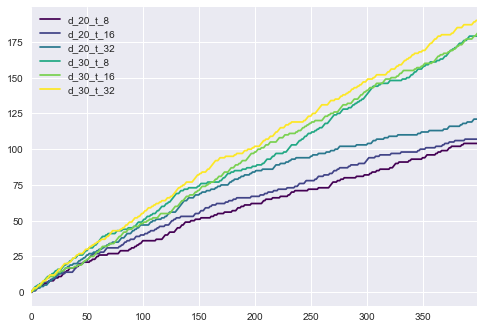

In [23]:
result_df.drop(columns='n_tests').plot(cmap='viridis')

In [25]:
result_df.iloc[100]

n_tests      100
d_20_t_8      36
d_20_t_16     40
d_20_t_32     47
d_30_t_8      50
d_30_t_16     48
d_30_t_32     55
Name: 100, dtype: int64